In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Object Tracking [Detecting a coloured object]

vid = cv.VideoCapture(0)

if not vid.isOpened():
    print('Error: Unable to open camera')
    exit()

while True:
    ret, frame = vid.read()
    if ret:
        hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)

        # HSV values for the colour we want to track
        lower_red = np.array([150, 150, 50])
        upper_red = np.array([180, 255, 150])

        lower_green = np.array([50, 100, 100])
        upper_green = np.array([80, 255, 255])

        lower_blue = np.array([100, 150, 0])
        upper_blue = np.array([140, 255, 255])

        mask_red = cv.inRange(hsv, lower_red, upper_red)
        mask_green = cv.inRange(hsv, lower_green, upper_green)
        mask_blue = cv.inRange(hsv, lower_blue, upper_blue)

        res_red = cv.bitwise_and(frame, frame, mask=mask_red)
        res_green = cv.bitwise_and(frame, frame, mask=mask_green)
        res_blue = cv.bitwise_and(frame, frame, mask=mask_blue)

        cv.imshow('frame', frame)
        cv.imshow('mask_blue', mask_blue)
        cv.imshow('res_blue', res_blue)

        if cv.waitKey(1) & 0xFF == ord('q'):
            break

vid.release()
cv.destroyAllWindows()

2024-08-01 15:15:21.394 python[13453:28862253] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


In [3]:
# Transformations

# 1. Scaling
img = cv.imread(cv.samples.findFile('dog.jpeg'))
if img is None:
    print('Error: Unable to read image')
    exit()

# INTER.CUBIC (better) or INTER.LINEAR for enlarging
# INTER_AREA for shrinking
dst = cv.resize(img, None, fx=2, fy=2, interpolation=cv.INTER_LINEAR)

# 2. Translation
rows, cols, _ = img.shape
M = np.float32([[1, 0, 100], [0, 1, 50]])

dst = cv.warpAffine(img, M, (cols, rows))
# Translates the image by 100 pixels to the right and 50 pixels down
# Formula used: dst(x, y) = src(M11x + M12y + M13, M21x + M22y + M23)

# 3. Rotation
M = cv.getRotationMatrix2D((cols/2, rows/2), 90, 0.5)
# Takes in (centre, angle, scale)

dst = cv.warpAffine(img, M, (cols, rows))

# 4. Affine Transformation

# We need to provide 3 points from input image and corresponding points in output image
pts1 = np.float32([[50, 50], [200, 50], [50, 200]])
pts2 = np.float32([[10, 100], [200, 50], [100, 250]])

# Converts to 2 x 3 affine matrix
M = cv.getAffineTransform(pts1, pts2)

# Affine Transformation: Preserves collinearity and ratios of distances, and parallel lines remain parallel
dst = cv.warpAffine(img, M, (cols, rows))

# 5. Perspective Transformation

# We need to provide 4 points from input image and corresponding points in output image
pts1 = np.float32([[56,65],[368,52],[28,387],[389,390]])
pts2 = np.float32([[0,0],[300,0],[0,300],[300,300]])

# Converts to 3 x 3 perspective matrix
M = cv.getPerspectiveTransform(pts1, pts2)

# Perspective Transformation: Preserves collinearity and ratios of distances, but parallel lines do not remain parallel
dst = cv.warpPerspective(img, M, (cols, rows))

cv.imshow('dst', dst)

if cv.waitKey(0) & 0xFF == ord('q'):
    cv.destroyAllWindows()


In [5]:
# Image Thresholding
# A way of partitioning (segmentation) by turning on/off pixels based on a certain threshold value

img = cv.imread(cv.samples.findFile('dog.jpeg'), cv.IMREAD_GRAYSCALE)
if img is None:
    print('Error: Unable to read image')
    exit()

# 1. Simple Thresholding

# Takes in source image, threshold value, max value, and type of thresholding
ret, thresh1 = cv.threshold(img, 127, 255, cv.THRESH_BINARY)

# THRESH_BINARY: If pixel value > threshold, set to max value, else set to 0
# THRESH_BINARY_INV: Opposite of THRESH_BINARY
# THRESH_TRUNC: If pixel value > threshold, set to threshold, else keep as is
# THRESH_TOZERO: If pixel value > threshold, keep as is, else set to 0
# THRESH_TOZERO_INV: Opposite of THRESH_TOZERO

# 2. Adaptive Thresholding
# Determines the threshold value for a pixel based on a small region around it

# Takes in source image, max value, adaptive method, type of thresholding, block size, and constant
# adaptive method: cv.ADAPTIVE_THRESH_MEAN_C or cv.ADAPTIVE_THRESH_GAUSSIAN_C [how threshold value is calculated]
# block size: size of the region around a pixel to calculate threshold value
# constant: a constant subtracted from the calculated threshold value
thresh2 = cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 11, 2)

cv.imshow('thresh2', thresh2)

if cv.waitKey(0) & 0xFF == ord('q'):
    cv.destroyAllWindows()

In [2]:
# Smoothing and Filtering Images

# Image Filtering
# Works by convolving the image with a kernel

img = cv.imread(cv.samples.findFile('dog.jpeg'))
if img is None:
    print('Error: Unable to read image')
    exit()

kernel = np.ones((5, 5), np.float32)/25
dst = cv.filter2D(img, -1, kernel)

# Image Blurring

# 1. Averaging
# Works by convolving the image with a normalized box filter
dst = cv.blur(img, (5, 5))

# 2. Gaussian Blurring
# Works by convolving the image with a Gaussian kernel, so that the pixel value is the weighted sum of the neighbouring pixels, with higher weights for pixels closer to the centre
dst = cv.GaussianBlur(img, (5, 5), 0)

# 3. Median Blurring
# Works by replacing the pixel value with the median value of the neighbouring pixels
dst = cv.medianBlur(img, 5)

# 4. Bilateral Filtering
# Works by preserving the edges while smoothing the image
# A Gaussian filter is applied in the space domain, and another Gaussian filter is applied in the intensity domain
# Higher weights are given to neighbouring pixels with similar intensity
# So, edges are preserved as the neighbouring pixels have different intensities

# Takes in source image, diameter of each pixel neighbourhood, sigma values for colour and space
dst = cv.bilateralFilter(img, 9, 75, 75)

cv.imshow('dst', dst)

if cv.waitKey(0) & 0xFF == ord('q'):
    cv.destroyAllWindows()


In [2]:
# Morphological Transformations
# Transformations on binary images with a kernel that determines the operation

img = cv.imread(cv.samples.findFile('dog.jpeg'), cv.IMREAD_GRAYSCALE)
if img is None:
    print('Error: Unable to read image')
    exit()

# 1. Erosion
# Erodes away the boundaries of the foreground object
# A pixel in the original image is considered 1 if all the pixels under the kernel are 1, otherwise it is eroded (made to 0)

kernel = np.ones((5, 5), np.uint8)
dst = cv.erode(img, kernel, iterations=1)

# 2. Dilation
# Opposite of erosion
# A pixel element is considered 1 if at least one pixel under the kernel is 1

dst = cv.dilate(img, kernel, iterations=1)

# 3. Opening
# Erosion followed by dilation
# Helps to remove noise, i.e. small white points in the image, apart from the part in focus

dst = cv.morphologyEx(img, cv.MORPH_OPEN, kernel)

# 4. Closing
# Dilation followed by erosion
# Helps to remove noise, i.e. small black points in the part in focus

dst = cv.morphologyEx(img, cv.MORPH_CLOSE, kernel)

# 5. Morphological Gradient
# Difference between dilation and erosion of an image
# Results looks like the outline of the objects

dst = cv.morphologyEx(img, cv.MORPH_GRADIENT, kernel)

cv.imshow('img', img)
cv.imshow('dst', dst)

if cv.waitKey(0) & 0xFF == ord('q'):
    cv.destroyAllWindows()


In [3]:
# Edge Detection

# Canny Edge Detection Algorithm is used:

# 1. Noise Reduction
# - Applies 5 x 5 Gaussian filter to smooth the image

# 2. Gradient Calculation
# - Smoothened image is filtered with a Sobel kernel to get first derivatives in x and y directions
# - From these, we can find the edge gradient and direction

# 3. Non-maximum Suppression: Gets rid of spurious response to edge detection
# - Compares the pixel value with the neighbours in the edge direction
# - If the pixel value is the maximum, it keeps it, otherwise it suppresses it

# 4. Hysteresis Thresholding: Determines which edges are real and which are not
# - Requires two threshold values: minVal and maxVal
# - If the pixel value is greater than maxVal, it is considered a strong edge
# - If the pixel value is less than minVal, it is considered a non-edge
# - If the pixel value is between the two, it is considered a weak edge


img = cv.imread(cv.samples.findFile('dog.jpeg'), cv.IMREAD_GRAYSCALE)
if img is None:
    print('Error: Unable to read image')
    exit()

# Takes in source image, min and max values for hysteresis thresholding, size of Sobel kernel for gradient calculation, L2gradient (True for more accurate calculation)
edges = cv.Canny(img, 100, 200)

cv.imshow('img', img)
cv.imshow('edges', edges)

if cv.waitKey(0) & 0xFF == ord('q'):
    cv.destroyAllWindows()

In [4]:
# Contours
# A curve joining all the continuous points having the same colour or intensity

img = cv.imread(cv.samples.findFile('dog.jpeg'))
if img is None:
    print('Error: Unable to read image')
    exit()

# Essentially, it separates the white (object) from the black (background)
# So, we need to convert the image to a binary image

gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(gray, 127, 255, 0)

# Takes in binary image, contour retrieval mode, and contour approximation method
# Contour retrieval mode: cv.RETR_TREE retrieves all the contours and creates a full hierarchy
# Contour approximation method: cv.CHAIN_APPROX_SIMPLE removes all redundant points and compresses the contour
# For example, for a rectangle, instead of entire boundary, only 4 corner points are stored

contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

# To draw contours, we use cv.drawContours
# Takes in source image, contours, contour index, colour, and thickness
# To draw all contours, contour index is -1
# cv.drawContours(img, contours, -1, (0, 255, 0), 3)

# Image Moments [TBD]

# Contour Features - Area, Perimeter
cnt = contours[2]
area = cv.contourArea(cnt)
perimeter = cv.arcLength(cnt, True)

# Contour Approximation
# Approximates a contour shape to another shape with less number of vertices

# Parameter that controls the approximation accuracy
epsilon = 0.01*cv.arcLength(cnt, True)
approx = cv.approxPolyDP(cnt, epsilon, True)

# Convex Hull
# Find the convex hull of a contour

hull = cv.convexHull(cnt)

# Bounding Rectangle

# 1. Straight Bounding Rectangle
# Does not consider rotation of the object

for cnt in contours:
    x, y, w, h = cv.boundingRect(cnt)
    cv.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 1)

# 2. Rotated Rectangle
# Considers rotation of the object

for cnt in contours:
    rect = cv.minAreaRect(cnt)
    box = cv.boxPoints(rect)
    box = np.int0(box)
    cv.drawContours(img, [box], 0, (0, 0, 255), 1)

# 3. Minimum Enclosing Circle
# Finds the circle that completely encloses the object

for cnt in contours:
    (x, y), radius = cv.minEnclosingCircle(cnt)
    center = (int(x), int(y))
    radius = int(radius)
    cv.circle(img, center, radius, (255, 0, 0), 1)

# 4. Fitting an Ellipse
# Fits an ellipse around the object

for cnt in contours:
    ellipse = cv.fitEllipse(cnt)
    cv.ellipse(img, ellipse, (255, 255, 0), 1)

# Contour Properties

# 1. Aspect Ratio
# Ratio of width to height of bounding rectangle
x, y, w, h = cv.boundingRect(cnt)
aspect_ratio = float(w)/h

# 2. Extent
# Ratio of contour area to bounding rectangle area
area = cv.contourArea(cnt)
x, y, w, h = cv.boundingRect(cnt)
rect_area = w*h
extent = float(area)/rect_area

# 3. Solidity
# Ratio of contour area to its convex hull area
area = cv.contourArea(cnt)
hull = cv.convexHull(cnt)
hull_area = cv.contourArea(hull)
solidity = float(area)/hull_area


cv.imshow('img', img)

if cv.waitKey(0) & 0xFF == ord('q'):
    cv.destroyAllWindows()


/var/folders/tq/5p_yzy594p13150svbv0sfsm0000gn/T/ipykernel_13943/2339932891.py:61: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)
/var/folders/tq/5p_yzy594p13150svbv0sfsm0000gn/T/ipykernel_13943/2339932891.py:86: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lefty = int((-x*vy/vx) + y)
/var/folders/tq/5p_yzy594p13150svbv0sfsm0000gn/T/ipykernel_13943/2339932891.py:87: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  righty = int(((cols-x)*vy/vx)+y)


error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'line'
> Overload resolution failed:
>  - Can't parse 'pt1'. Sequence item with index 1 has a wrong type
>  - Can't parse 'pt1'. Sequence item with index 1 has a wrong type


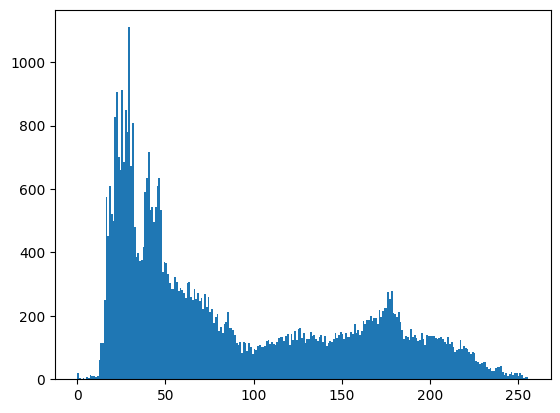

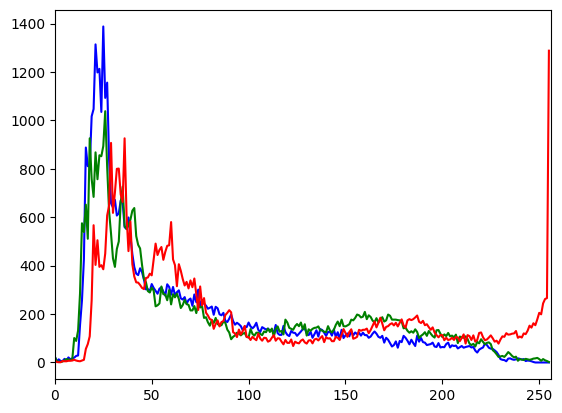

In [2]:
# Histograms
# A graphical representation of the intensity distribution of an image

img = cv.imread(cv.samples.findFile('dog.jpeg'), cv.IMREAD_GRAYSCALE)

# Takes in source image, channels, mask, histSize, ranges
# channels: [0] for grayscale, [0, 1, 2] for colour
# mask: If part of image is to be studied, otherwise None
# histSize: number of bins
# ranges: range of intensity values

hist = cv.calcHist([img], [0], None, [256], [0, 256])

# Alternative
hist, bins = np.histogram(img.ravel(), 256, [0, 256])

# Plotting Histograms

# For grayscale image
plt.hist(img.ravel(), 256, [0, 256])
plt.show()

# For colour image
img = cv.imread(cv.samples.findFile('dog.jpeg'))
color = ('b', 'g', 'r')
for i, col in enumerate(color):
    histr = cv.calcHist([img], [i], None, [256], [0, 256])
    plt.plot(histr, color=col)
    plt.xlim([0, 256])
plt.show()

# Histogram Equalization
# Improves the contrast of an image by spreading out the intensity values

img = cv.imread(cv.samples.findFile('dog.jpeg'), cv.IMREAD_GRAYSCALE)
if img is None:
    print('Error: Unable to read image')
    exit()

equ = cv.equalizeHist(img)
dst = np.hstack((img, equ))

# CLAHE (Contrast Limited Adaptive Histogram Equalization)
# Global histogram equalization can lead to over-amplification of noise, and loss of information in regions that are already well-contrasted
# CLAHE divides the image into small tiles, and applies histogram equalization to each tile
# To avoid over-amplification, the contrast limiting is applied - if a histogram bin is above the specified limit, the pixels are clipped and distributed uniformly

clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
cl = clahe.apply(img)

dst = np.hstack((img, equ, cl))

cv.imshow('dst', dst)

if cv.waitKey(0) & 0xFF == ord('q'):
    cv.destroyAllWindows()



In [3]:
# Hough Transform
# Used to detect shapes in an image

img = cv.imread(cv.samples.findFile('test.png'))
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
edges = cv.Canny(gray, 50, 150, apertureSize=3)

# Hough Line Transform
lines = cv.HoughLines(edges, 1, np.pi/180, 200)

for line in lines:
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    cv.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)

cv.imshow('img', img)

if cv.waitKey(0) & 0xFF == ord('q'):
    cv.destroyAllWindows()